Electric bikes are still new and changing https://www.lyft.com/bikes/bay-wheels/service-log
studies on bike share effects on cities: https://www.outsideonline.com/2136406/do-bike-share-systems-actually-work

TODO:
- translate writeup to slides (drop lots of stuff, present what's important)
- check rubric

tangential project: unsupervised clustering
- end lat/long can be a 2 feature project
- graph lat/long and find clusters, that's basically it
- can use distance to nearest station to change point color or alpha (?)
- use overlay of actual map
- use actual station lat/long overlay in gray

# minimal viable product

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from geopy.distance import geodesic
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')

In [11]:
def grab_data(url):

    # start with data we want
    df = pd.read_csv(url, usecols=['ended_at', 'started_at', 'start_station_id', 'rideable_type',
                                   'end_station_id', 'end_lat', 'end_lng', 'member_casual'])

    # drop rows w/o lat/long coordinates
    df = df[df['end_lat'].notna()]

    # drop non-electric bikes
    df = df[df['rideable_type'] == 'electric_bike']
    df.reset_index(drop=True)
    df = df.drop(columns='rideable_type')
    
    # grab date (for data matching)
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['date'] = pd.to_datetime(df['ended_at'].dt.date)
    
    # add a few time related features
    df['hour'] = df['ended_at'].dt.hour
    
    df['started_at'] = pd.to_datetime(df['started_at'])
    
    # daylight savings makes a few negative trip times, a quick approx. fix is okay
    df['trip_time'] = abs((df['ended_at'] - df['started_at']).dt.total_seconds())
    
    df = df.drop(columns=['ended_at', 'started_at'])
    
    # binary encoding for a few categorical features
    df['start_station_id'] = df['start_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['member_casual'] = df['member_casual'].apply(lambda x: 0 if x=='casual' else 1)
    
    return df

grab_data('data/SF/202010-baywheels-tripdata.csv')

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0
...,...,...,...,...,...,...,...,...
167535,1,SF-M15,37.765940,-122.449298,0,2020-10-27,16,710.0
167536,1,SF-M15,37.765958,-122.449482,0,2020-10-30,20,1422.0
167537,1,SF-M15,37.765931,-122.449308,0,2020-10-01,16,1433.0
167538,1,SF-M15,37.765935,-122.449313,1,2020-10-26,17,1484.0


In [12]:
def grab_geo(city):
    if city == 'SF':
        geo1 = pd.read_csv('data/SF/202010-baywheels-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
        geo2 = pd.read_csv('data/SF/202011-baywheels-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
    elif city == 'CH':
        geo1 = pd.read_csv('data/CH/202010-divvy-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
        geo2 = pd.read_csv('data/CH/202011-divvy-tripdata.csv', usecols=['end_station_id', 'end_lat', 'end_lng'])
    else:
        return None
        
    geo = pd.concat([geo1, geo2], ignore_index=True).groupby(by='end_station_id').agg(np.mean)
    
    geo = geo[geo['end_lat'].notna()]
    
    return geo

In [32]:
ch_s_geo = grab_geo('CH')

ch_s_geo

,end_lat,end_lng
end_station_id,,
2.0,41.876487,-87.620501
3.0,41.867235,-87.615345
4.0,41.856100,-87.613244
5.0,41.874070,-87.627702
6.0,41.886930,-87.612819
...,...,...
727.0,41.687412,-87.655446
728.0,41.691235,-87.681308
730.0,41.691320,-87.712825


In [34]:
# RERUN THIS GUY if you need the station coordinates

sf = grab_data('data/SF/202010-baywheels-tripdata.csv')

# df of station lat/long indexed by station id

sf_s_geo = sf[['end_station_id', 'end_lat', 'end_lng']].groupby(by='end_station_id').agg(np.mean)

# example of how to get the lat/long out
sf_s_geo.loc['SJ-R11'] #['BK-A3']

end_lat     37.320247
end_lng   -121.870024
Name: SJ-R11, dtype: float64

In [35]:
sf_s_geo

,end_lat,end_lng
end_station_id,,
OK-L6,37.803178,-122.270921
SF I29-1,37.783516,-122.393187
SF-A19,37.805325,-122.437234
SF-A20,37.804442,-122.433609
SF-A27,37.804609,-122.403381
...,...,...
SJ-Q5,37.311235,-121.896284
SJ-Q8,37.317184,-121.884890
SJ-Q9,37.318463,-121.883134


In [22]:
stat_id = 'SJ-R11'

tuple([val for idx, val in sf_s_geo.loc[stat_id].items()])

(37.32024700833334, -121.87002400000002)

In [23]:
# geopy: calculates distance between lat/long coordinates

station_1 = 'SJ-R11'
geo_1 = tuple([val for idx, val in sf_s_geo.loc[station_1].items()])

station_2 = 'SF-A27'
geo_2 = tuple([val for idx, val in sf_s_geo.loc[station_2].items()])

geodesic(geo_1, geo_2).km

71.48788001935807

In [13]:
def station_dist(row, input_geo):
    '''Returns the distance between an input coordinate set 
    and a row coordinate set.
    
    Applied to the station coordinate dataframe, can be used 
    to make a new column of distances from a specific point
    in space.
    '''
    
    # geopy uses lat/long tuples to calculate distance
    stat_geo = tuple([val for idx, val in row.items()])
    
#     print(input_geo)
#     print(stat_geo)
    
    return geodesic(stat_geo, input_geo).km

In [14]:
def nearest_station(row, df, station_geo):
    '''doc string'''
    
    # quick progress tracker
    if row.name%2000 == 0:
        print(round(row.name/254000, 3))
    
    # get row values (I don't know a better way to do this)
    # this row expects lat/long in a specific column position
    # if df is changed beforehand the following lines will mess up
    row_vals = [val for idx, val in row.items()]
    
    # if statement to catch rows where bikes are already at a station
    if not pd.isna(row_vals[1]):
        return 0, row_vals[1]
    
    # get row lat/long
    row_geo = tuple(row_vals[2:4])
    
    # get distance to each station
    s_geo = station_geo.copy()
    s_geo['dist'] = s_geo.apply(station_dist, args=[row_geo], axis=1)
    
    # grab the minimum distance and station name
    min_id = s_geo['dist'].idxmin()
    min_dist = s_geo.at[min_id, 'dist']*1000
    
    # can return station name and distance (or just distance) in meters
    return min_dist, min_id

In [12]:
# The big computation

sf['closest_dist'], sf['closest_id'] = zip(*sf.apply(nearest_station, args=[sf], axis=1))

sf

0.0
0.009
0.018
0.027
0.036
0.045
0.054
0.063
0.072
0.081
0.09
0.126
0.162
0.18
0.189
0.198
0.234
0.243
0.252
0.261
0.27
0.279
0.288
0.315
0.333
0.351
0.36
0.387
0.396
0.405
0.423
0.432
0.441
0.45
0.459
0.486
0.495
0.505
0.514
0.523
0.532
0.559
0.568
0.577
0.613
0.631
0.649
0.658
0.667
0.676
0.694
0.703
0.712
0.721
0.73
0.748
0.766
0.784
0.802
0.811
0.82
0.829
0.838
0.856
0.865
0.883
0.892
0.901
0.91
0.919
0.928
0.946
0.955
0.964
0.973
0.982
0.991


,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [13]:
sf.to_csv('mvp.csv')

In [46]:
sf = pd.read_csv('data/mvp.csv', index_col='Unnamed: 0')

sf

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [24]:
# pre-ML processing

X = sf.copy()

X = X.drop(columns=['started_at', 'ended_at', 'closest_id'])

X['start_station_id'] = X['start_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

X['end_station_id'] = X['end_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

X['member_casual'] = X['member_casual'].apply(lambda x: 0 if x=='casual' else 1)

scaler = StandardScaler()

X_s = scaler.fit_transform(X)

X_s

array([[-1.3533168 , -1.24244838,  0.43907207, -0.3706261 , -0.8899798 ,
        -0.02297153],
       [-1.3533168 , -1.24244838,  0.56897758, -0.3706261 , -0.8899798 ,
         0.38030297],
       [-1.3533168 , -1.24244838,  0.50402483, -0.42391351, -0.8899798 ,
         0.06010198],
       ...,
       [ 0.73892528,  0.80486241,  0.33344807, -0.34686968,  1.12362101,
        -0.35143748],
       [ 0.73892528,  0.80486241,  0.33339719, -0.34633059, -0.8899798 ,
        -0.35143748],
       [ 0.73892528,  0.80486241,  0.45866291, -0.20008063, -0.8899798 ,
        -0.35143748]])

In [25]:
X_s[:, -1:]

array([[-0.02297153],
       [ 0.38030297],
       [ 0.06010198],
       ...,
       [-0.35143748],
       [-0.35143748],
       [-0.35143748]])

In [26]:
y = X_s[:, -1:]
X_s = X_s[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X_s, y)

model = LinearRegression().fit(X_train, y_train)

In [27]:
yhat = model.predict(X_test)

# check supervised case study for metric and inference methods
mean_squared_error(y_test, yhat)

0.7161132690815011

In [29]:
X.columns

Index(['start_station_id', 'end_station_id', 'end_lat', 'end_lng',
       'member_casual', 'closest_dist'],
      dtype='object')

<BarContainer object of 5 artists>

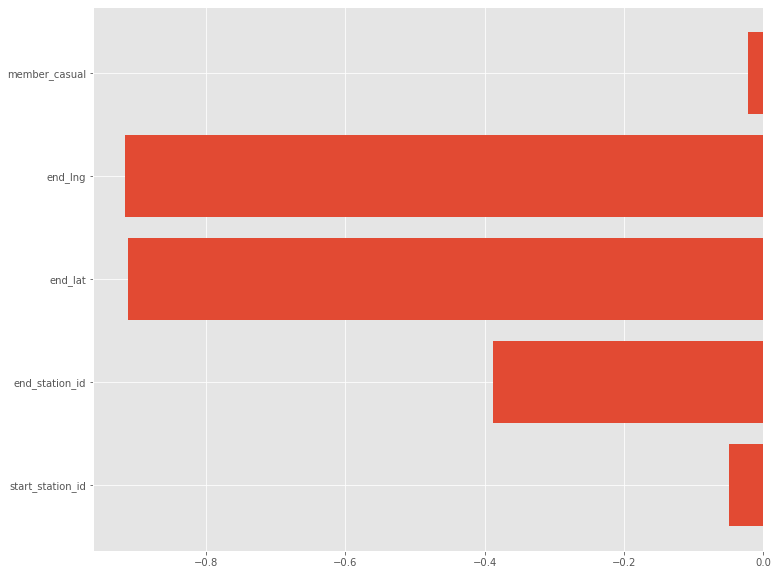

In [30]:
fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X.columns[:-1], model.coef_[0])

# Adding other data

- time (day of week)
- start/stop distance (trip distance proxy) data leakage?

In [188]:
# weather data

def grab_weather(city):
    
    if city == 'CH':
        url = 'data/CH/99733899999.csv'
    elif city == 'SF':
        url = 'data/SF/99401699999.csv'
    else:
        return None

    dfw = pd.read_csv(url, usecols=['DATE', 'TEMP', 'WDSP'])

    dfw['DATE'] = pd.to_datetime(dfw['DATE'])
    
    return dfw

grab_weather(city='SF')

,DATE,TEMP,WDSP
0,2020-01-01,53.4,4.1
1,2020-01-02,53.9,4.1
2,2020-01-03,51.6,4.8
3,2020-01-04,53.5,4.2
4,2020-01-05,51.5,3.4
...,...,...,...
357,2020-12-27,49.7,3.0
358,2020-12-28,50.0,7.9
359,2020-12-29,48.5,3.1
360,2020-12-30,49.2,3.2


In [189]:
# traffic data

def grab_traffic(city):
    
    if city == 'CH':
        dft = pd.read_csv('data/CH/CTA_-_Ridership_-_Daily_Boarding_Totals.csv',
                         usecols=['service_date', 'total_rides'])

        dft['service_date'] = pd.to_datetime(dft['service_date'])
        
        return dft
    
    elif city == 'SF':
        dft = pd.read_csv('data/SF/TaxiTable.csv')

        dft['Day of Date'] = pd.to_datetime(dft['Day of Date'])
        dft['Number of Records'] = dft['Number of Records'].replace(',', '', regex=True).astype('int32')
        dft = dft.rename(columns={'Number of Records':'taxi_trips'})
        
        return dft
    
    else:
        return None

grab_traffic('SF')

,Day of Date,taxi_trips
0,2020-09-22,7
1,2021-03-29,14
2,2020-09-23,50
3,2020-09-18,382
4,2020-03-29,1162
...,...,...
378,2020-03-13,6870
379,2020-03-12,7451
380,2020-03-11,7556
381,2020-03-10,7714


In [43]:
sf1 = grab_data('data/SF/202010-baywheels-tripdata.csv')
sf2 = grab_data('data/SF/202011-baywheels-tripdata.csv')

# df of two cities
sf = pd.concat([sf1, sf2], ignore_index=True)

# adding traffic column
sf = sf.merge(grab_traffic('SF'), how='left', left_on='date', right_on='Day of Date').drop(columns='Day of Date')

# adding weather columns
sf = sf.merge(grab_weather('SF'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data
sf = sf[sf['TEMP'].notna()]

sf

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5
...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0


In [44]:
# another BIG COMPUTATION

sf_s_geo = grab_geo('SF')

sf['closest_dist'], sf['closest_id'] = zip(*sf.apply(nearest_station, args=[sf, sf_s_geo], axis=1))

sf

0.0
0.009
0.019
0.028
0.038
0.047
0.057
0.066
0.075
0.085
0.094
0.104
0.113
0.123
0.132
0.142
0.151
0.16
0.17
0.179
0.189
0.198
0.208
0.217
0.226
0.236
0.245
0.255
0.264
0.274
0.283
0.292
0.302
0.311
0.321
0.33
0.34
0.349
0.358
0.368
0.377
0.387
0.396
0.406
0.415
0.425
0.434
0.443
0.453
0.462
0.472
0.481
0.491
0.5
0.509
0.519
0.528
0.538
0.547
0.557
0.566
0.575
0.585
0.594
0.604
0.613
0.623
0.632
0.642
0.651
0.66
0.679
0.689
0.698
0.708
0.717
0.726
0.736
0.745
0.755
0.764
0.774
0.783
0.792
0.802
0.811
0.821
0.83
0.84
0.849
0.858
0.877
0.896
0.906
0.915
0.925
0.934
0.943
0.953
0.962
0.972
0.981
0.991


,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [46]:
sf.to_csv('data/sf2.csv')

# modeling

In [118]:
# grab processed data from before and make a few tweaks for modeling
sf2 = pd.read_csv('data/sf2.csv', index_col='Unnamed: 0')

# drop rows w/o weather data (should be 0 now)
sf2 = sf2[sf2['TEMP'].notna()]

# drop rows w/ distances greater than 2.6km (1600 trips)
# these are more than 3 standevs away from (non-0) distance mean
sf2 = sf2[sf2['closest_dist'] < 2600]

# fix negative trip times
sf2['trip_time'] = abs(sf2['trip_time'])

sf2

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [63]:
# splitting data up

X = sf2.copy()

y = X['closest_dist']
X = X.drop(columns=['end_station_id', 'date', 'closest_id', 'closest_dist', 'end_lat', 'end_lng'])

# EXPERIMENTAL
# y = y.apply(lambda x: 0 if x == 0 else math.log10(x))

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

,start_station_id,member_casual,hour,trip_time,taxi_trips,TEMP,WDSP
109594,1,1,19,418.0,2612,60.1,5.3
69649,1,0,15,644.0,4174,58.1,4.1
145641,1,1,14,708.0,4009,51.6,5.1
47875,0,0,11,1926.0,3874,61.4,3.7
19449,0,0,17,778.0,4483,54.1,5.5
...,...,...,...,...,...,...,...
125618,1,0,19,575.0,3896,53.0,3.4
165197,1,0,11,180.0,3827,57.3,7.2
127318,0,1,12,630.0,4072,52.9,5.9
35351,0,1,16,896.0,3865,59.6,3.9


In [65]:
# baseline model. Trying to get an RMSE better than 360!
# changes based on train test split some
y_base = np.ones(y_test.shape[0])*(sf2['closest_dist'].mean())

mean_squared_error(y_test, y_base)**0.5

362.32578985321567

In [107]:
sf2['closest_dist'].mean()

166.03008241444383

In [60]:
# just a quick check to see what a non-parametric model can do (rmse 8.6)
# may need scaled data from below

rf = RandomForestRegressor().fit(X_train_scaled, y_train)

rfhat = rf.predict(X_test_scaled)

mean_squared_error(y_test, rfhat)**0.5

360.12089675421447

In [66]:
# Scaling data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [67]:
# Basic linear model w/ default hyperparameters
model_sf = LinearRegression().fit(X_train_scaled, y_train)

yhat = model_sf.predict(X_test_scaled)

In [68]:
# RMSE of basic model: 319. Better than 360 but can be improved
mean_squared_error(y_test, yhat)**0.5

348.81718714654016

In [57]:
# Grid search for optimizing hyperparameter tuning
r_grid = {'alpha':np.linspace(0, 1, 101)}

r_gridsearch = GridSearchCV(Ridge(),
                             r_grid,
                             verbose=True,
                             scoring='neg_mean_squared_error')
r_gridsearch.fit(X_train_scaled, y_train)

print("best parameters:", r_gridsearch.best_params_)

Fitting 5 folds for each of 101 candidates, totalling 505 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


best parameters: {'alpha': 1.0}


[Parallel(n_jobs=1)]: Done 505 out of 505 | elapsed:    6.6s finished


In [69]:
# Such a small improvement it mocks me, I guess feature engineering would be the only next step.
model2_sf = Ridge(alpha=1).fit(X_train_scaled, y_train)

yhat = model2_sf.predict(X_test_scaled)

mean_squared_error(y_test, yhat)**0.5

348.81718578102254

<BarContainer object of 7 artists>

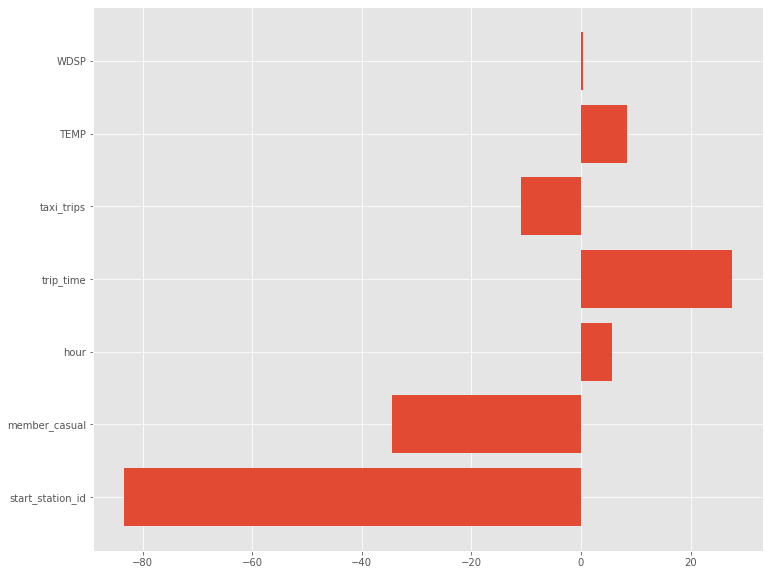

In [70]:
# Interpret this model
# not much better than baseline so not to be relied on too much
# also note that categorical feature (member/casual and start station) cannot be directly compared to numeric

fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X_test.columns, model2_sf.coef_)

In [46]:
model2_sf.coef_

array([-5.94401293e+01, -6.87371865e+02, -6.54863345e+02, -3.77160197e+01,
       -1.80856337e+00,  9.12972926e+00, -6.38634283e+00,  6.54814724e+00,
       -4.83624890e-01])

<BarContainer object of 7 artists>

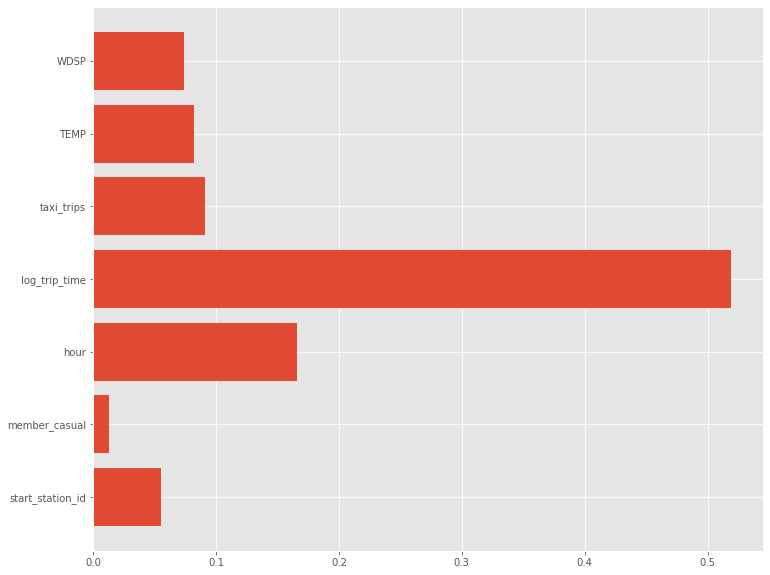

In [61]:
# random forest feature importance graph
# not as directly interpretable and this model did worse than linear (don't use)

fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X_test.columns, rf.feature_importances_)

## classifier

In [73]:
# grab processed data from before and make a few tweaks for modeling
sf2 = pd.read_csv('data/sf2.csv', index_col='Unnamed: 0')

# drop rows w/o weather data (should be 0 now)
sf2 = sf2[sf2['TEMP'].notna()]

# fix negative trip times
sf2['trip_time'] = abs(sf2['trip_time'])

# code target variable
sf2['end_station_id'] = sf2['end_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

sf2

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
0,0,0,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,0,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,0,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,0,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,0,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,1,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,1,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,1,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,1,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [74]:
# splitting data up

X = sf2.copy()

y = X['end_station_id']
X = X.drop(columns=['end_station_id', 'date', 'closest_id', 'closest_dist', 'end_lat', 'end_lng'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

,start_station_id,member_casual,hour,trip_time,taxi_trips,TEMP,WDSP
187974,1,1,10,585.0,3705,50.5,3.9
210282,0,0,12,716.0,2491,52.6,10.3
15761,1,0,18,885.0,4647,63.4,3.9
23398,0,1,9,1267.0,3871,61.6,12.7
145787,0,1,14,1629.0,3302,52.8,4.5
...,...,...,...,...,...,...,...
98464,1,1,14,301.0,4174,58.1,4.1
77619,1,1,10,688.0,3865,59.6,3.9
59046,1,0,16,3742.0,3788,58.1,3.8
4891,0,0,17,1378.0,4174,58.1,4.1


In [76]:
# baseline model. Trying to get a MSE lower than 0.40
# changes based on train test split some
y_base = np.ones(y_test.shape[0])

mean_squared_error(y_test, y_base)

0.39870132357729804

In [80]:
# Scaling data
scaler2 = StandardScaler()

scaler2.fit(X_train)

X_train_scaled = scaler2.transform(X_train)

X_test_scaled = scaler2.transform(X_test)

In [82]:
# non-tuned model
model3_sf = LogisticRegression().fit(X_train_scaled, y_train)

yhat_3 = model3_sf.predict(X_test_scaled)

In [85]:
# accuracy measure
acc_lr = mean_squared_error(y_test, yhat_3)

# precision measure
prc_lr = precision_score(y_test, yhat_3)

# recall measure
rec_lr = recall_score(y_test, yhat_3)

print('logistic regression:\n  accuracy: {}\n  precision: {}\n  recall: {}'.format(acc_lr, prc_lr, rec_lr))

logistic regression:
  accuracy: 0.32555021357289254
  precision: 0.7031841020719246
  recall: 0.793546126401631


In [86]:
lr_grid = {'penalty': ['l1', 'l2', 'none'],
           'C': np.linspace(0,1,11)}

lr_gridsearch = GridSearchCV(LogisticRegression(),
                             lr_grid,
                             verbose=True,
                             scoring='neg_mean_squared_error')
lr_gridsearch.fit(X_train_scaled, y_train)

print("best parameters:", lr_gridsearch.best_params_)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("

/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_pa

/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn

/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penal

best parameters: {'C': 0.0, 'penalty': 'none'}


[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    6.5s finished
/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [87]:
# non-tuned model
model4_sf = LogisticRegression(C=0, penalty='none').fit(X_train_scaled, y_train)

yhat_4 = model4_sf.predict(X_test_scaled)

/home/nicholas/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [88]:
# accuracy measure
acc_lr = mean_squared_error(y_test, yhat_4)

# precision measure
prc_lr = precision_score(y_test, yhat_4)

# recall measure
rec_lr = recall_score(y_test, yhat_4)

print('logistic regression:\n  accuracy: {}\n  precision: {}\n  recall: {}'.format(acc_lr, prc_lr, rec_lr))

logistic regression:
  accuracy: 0.32553105905338364
  precision: 0.7032039520112915
  recall: 0.793546126401631


<BarContainer object of 7 artists>

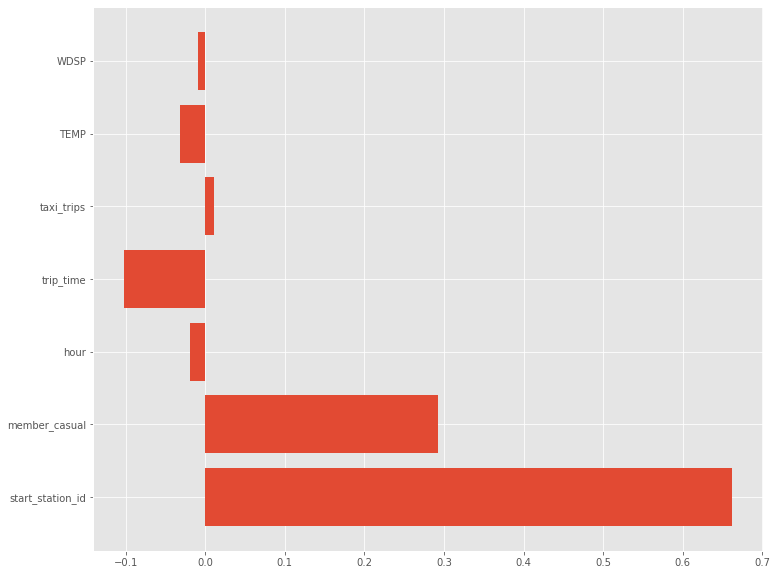

In [89]:
fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X_train.columns, model4_sf.coef_[0])

# SF target EDA
40% of rides did not end at a docking station. Among those undocked 16% were within 100 meters of a station while 12% were more than a kilometer away from any station.

Top 5 almost docked stations and circle showing average distance away: [map](https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B1457.13%2C37.7727156%2C-122.5089787%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B78.84%2C37.3393721%2C-121.8900498%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B210.27%2C37.7881975%2C-122.4203988%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B646.2%2C37.8026239%2C-122.4359166%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B200.68%2C37.7810937%2C-122.4118281%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D) and [website](https://www.mapdevelopers.com/draw-circle-tool.php). Four in SF and one very small one in San Jose.

A couple tousand rides ended within 100 meters of the nearest station. That's close enough to see the station in most cases and not an insignificant proportion so this is really worth investigating. It could be simple fixes such as having enough docking ports, having ports on both sides of busy roads, making the station itself easier to see, or keeping the app updated.


In [217]:
yp = sf3[sf3['closest_dist'] > 0].closest_dist
print('percentage of rides within 50 meters:', len(yp[yp < 50])/len(yp)*100)

percentage of rides within 50 meters: 1.1063431941314668


(array([9.230e+02, 0.000e+00, 1.961e+03, 5.790e+02, 6.419e+03, 1.684e+03,
        3.950e+03, 2.175e+03, 2.353e+03, 0.000e+00, 7.830e+02, 1.929e+03,
        8.320e+02, 4.032e+03, 5.907e+03, 4.356e+03, 2.059e+03, 1.311e+03,
        0.000e+00, 3.607e+03, 3.016e+03, 0.000e+00, 1.600e+01, 8.570e+02,
        1.430e+02, 2.466e+03, 1.351e+03, 2.450e+02, 1.573e+03, 1.480e+03,
        1.897e+03, 1.798e+03, 1.810e+02, 3.090e+02, 7.900e+01, 1.617e+03,
        4.500e+02, 1.130e+02, 2.720e+02, 0.000e+00, 0.000e+00, 4.230e+02,
        7.900e+02, 0.000e+00, 7.600e+02, 1.280e+02, 3.700e+02, 4.690e+02,
        1.200e+02, 2.790e+02, 5.770e+02, 1.510e+02, 1.130e+02, 1.000e+00,
        2.550e+02, 1.100e+01, 2.820e+02, 3.850e+02, 0.000e+00, 7.320e+02]),
 array([ 29.63543652,  41.23979026,  52.84414401,  64.44849775,
         76.05285149,  87.65720523,  99.26155897, 110.86591271,
        122.47026645, 134.07462019, 145.67897393, 157.28332767,
        168.88768141, 180.49203515, 192.09638889, 203.70074264,
  

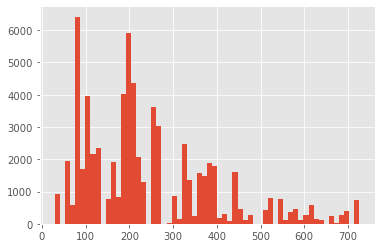

In [70]:
# graph of nearest distances that aren't 0 and less than 750m
# seem to be spikes at ~80m and ~190m, see if these are being left in a consistent location
# if they are then that's a good motivation to put a station there
# eg y>64 and y<87 and then plot all lat/long on a graph? also 180-203

fig, ax = plt.subplots()

yp = y[y>0]
yp = yp[y<750]

ax.hist(yp, bins=60)

# ~80m spike is mostly SJ-L10 and SF-L20; ~190 spike is partly SF-I25 and SF-I22
# SJ-L10 and SF-I25 were biggest proportion of bins and both were in the 
# top 5 undocked so this measure reiterates need to address them both

In [127]:
# more noise, but maybe SF-I25 and SF-I22
mask = (sf2['closest_dist'] > 180) & (sf2['closest_dist'] < 203) & (sf2['closest_id'] == 'SF-I22')

sf2[mask]

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
33,0,NaN,37.78,-122.42,0,2020-10-20,23,3165.0,3834,55.6,5.6,185.168741,SF-I22
44,0,NaN,37.78,-122.42,0,2020-10-14,5,357.0,4035,65.5,3.6,185.168741,SF-I22
48,0,NaN,37.78,-122.42,0,2020-10-12,2,546.0,3317,62.3,3.6,185.168741,SF-I22
93,0,NaN,37.78,-122.42,0,2020-10-06,16,788.0,4124,53.1,6.1,185.168741,SF-I22
94,0,NaN,37.78,-122.42,0,2020-10-06,5,1304.0,4124,53.1,6.1,185.168741,SF-I22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209977,1,NaN,37.78,-122.42,0,2020-11-28,21,453.0,2576,52.1,7.0,185.168741,SF-I22
209978,1,NaN,37.78,-122.42,0,2020-11-17,16,425.0,3883,58.7,6.6,185.168741,SF-I22
209980,1,NaN,37.78,-122.42,0,2020-11-10,23,385.0,4218,50.0,3.4,185.168741,SF-I22
210012,1,NaN,37.78,-122.42,0,2020-11-13,15,451.0,4072,52.9,5.9,185.168741,SF-I22


In [123]:
# can put SJ-L10 or SF-L20 in mask (make up 1/2 and 1/3 of spike respectively)
mask = (sf2['closest_dist'] > 64) & (sf2['closest_dist'] < 87) & (sf2['closest_id'] == 'SF-L20')

sf2[mask]

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,taxi_trips,TEMP,WDSP,closest_dist,closest_id
4,0,NaN,37.77,-122.43,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
8,0,NaN,37.77,-122.43,0,2020-10-30,17,396.0,4483,54.1,5.5,78.597538,SF-L20
37,0,NaN,37.77,-122.43,0,2020-10-10,15,528.0,3125,59.7,4.4,78.597538,SF-L20
80,0,NaN,37.77,-122.43,0,2020-10-08,16,867.0,3852,58.7,4.3,78.597538,SF-L20
82,0,NaN,37.77,-122.43,0,2020-10-28,16,361.0,3865,59.6,3.9,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209926,1,NaN,37.77,-122.43,0,2020-11-25,18,239.0,3951,53.3,5.8,78.597538,SF-L20
209961,1,NaN,37.77,-122.43,0,2020-11-22,9,652.0,2215,51.5,3.6,78.597538,SF-L20
210013,1,NaN,37.77,-122.43,0,2020-11-04,20,291.0,4088,56.2,4.7,78.597538,SF-L20
210053,1,NaN,37.77,-122.43,1,2020-11-14,17,419.0,2850,53.1,6.2,78.597538,SF-L20


In [226]:
def undocked_stations(city):
    if city == 'SF':
        df = pd.read_csv('data/sf2.csv', index_col='Unnamed: 0')
    elif city == 'CH':
        df = pd.read_csv('data/ch1.csv', index_col='Unnamed: 0')
    else:
        return None
    
    df = df[df['closest_dist'] > 0]
    
    df = df[['closest_id', 'closest_dist']]
    
    df = df.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'count'), ascending=False)
    
    return df.merge(grab_geo(city), left_index=True, right_index=True)

undocked_stations('SF')

/home/nicholas/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(closest_dist, mean)","(closest_dist, count)",end_lat,end_lng
SF-J1,1449.652736,3417,37.772920,-122.508980
SJ-L10,82.353959,3249,37.339261,-121.889917
SF-F23,205.482535,2202,37.788184,-122.420452
SF-B19,654.205294,2176,37.802621,-122.436149
SF-I25,196.425995,2141,37.781035,-122.411808
...,...,...,...,...
SF-S30,574.493968,5,37.750119,-122.386517
SJ-D9,982.697953,2,37.365260,-121.916720
SF-M30-2,563.711037,2,37.769250,-122.386328
SF-O30-2,658.663199,2,37.760340,-122.387463


In [225]:
# among trips not docked, this is a list of stations 
# and the count of bikes nearest them and average distances from them

y_stations = sf3[sf3['closest_dist'] > 0]

y_stations = y_stations[['closest_id', 'closest_dist']]

# can sort by count or by mean, just change argument in sort_values()
y_stations = y_stations.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'count'), ascending=False)

y_stations.merge(grab_geo('SF'), left_index=True, right_index=True)

/home/nicholas/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(closest_dist, mean)","(closest_dist, count)",end_lat,end_lng
SF-J1,1449.652736,3417,37.772920,-122.508980
SJ-L10,82.353959,3249,37.339261,-121.889917
SF-F23,205.482535,2202,37.788184,-122.420452
SF-B19,654.205294,2176,37.802621,-122.436149
SF-I25,196.425995,2141,37.781035,-122.411808
...,...,...,...,...
SF-S30,574.493968,5,37.750119,-122.386517
SJ-D9,982.697953,2,37.365260,-121.916720
SF-M30-2,563.711037,2,37.769250,-122.386328
SF-O30-2,658.663199,2,37.760340,-122.387463


In [222]:
sdf4 = pd.read_csv('data/SF/202011-baywheels-tripdata.csv')

sdf4[sdf4['start_station_id'] == 'SF-J1']

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
36317,DFD3680842124936,electric_bike,2020-11-14 13:46:16,2020-11-14 14:38:49,48th Ave at Cabrillo St,SF-J1,Jackson St at Polk St,SF-E23,37.772930,-122.509094,37.794448,-122.421512,member
36903,186C819BA47CCAC6,electric_bike,2020-11-24 12:15:56,2020-11-24 12:29:33,48th Ave at Cabrillo St,SF-J1,21st Ave at Geary Blvd,SF-G8,37.772849,-122.509031,37.779873,-122.480463,casual
38075,359216555DEAAF8C,electric_bike,2020-11-03 13:37:32,2020-11-03 14:17:14,48th Ave at Cabrillo St,SF-J1,S Van Ness Ave at Market St,SF-J23-2,37.772814,-122.509045,37.770886,-122.455473,member
40108,E6E01C8642434CEA,docked_bike,2020-11-15 16:08:47,2020-11-15 16:46:12,48th Ave at Cabrillo St,SF-J1,Central Ave at Fell St,SF-K17,37.772954,-122.509071,37.773311,-122.444293,casual
44601,D4362E73261B9BDA,docked_bike,2020-11-04 15:36:16,2020-11-04 16:20:55,48th Ave at Cabrillo St,SF-J1,48th Ave at Cabrillo St,SF-J1,37.772954,-122.509071,37.772954,-122.509071,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132236,CF0D987D578FEEBB,classic_bike,2020-11-27 15:49:44,2020-11-27 16:24:48,48th Ave at Cabrillo St,SF-J1,Broderick St at Oak St,SF-K18,37.772954,-122.509071,37.773063,-122.439078,casual
132237,DB88C005705D9B40,docked_bike,2020-11-15 13:31:05,2020-11-15 13:53:12,48th Ave at Cabrillo St,SF-J1,Funston Ave at Fulton St,SF-J10,37.772954,-122.509071,37.773263,-122.471230,casual
132238,5AE3820C5CA59F9A,docked_bike,2020-11-15 17:01:53,2020-11-15 17:26:07,48th Ave at Cabrillo St,SF-J1,Funston Ave at Fulton St,SF-J10,37.772954,-122.509071,37.773263,-122.471230,casual
132239,15258BEECD51B836,electric_bike,2020-11-27 14:02:49,2020-11-27 14:35:18,48th Ave at Cabrillo St,SF-J1,Funston Ave at Fulton St,SF-J10,37.772876,-122.509049,37.773521,-122.471277,casual


array([[<AxesSubplot:xlabel='start_station_id', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='end_lat', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='end_lng', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='member_casual', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='hour', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='trip_time', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='taxi_trips', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='TEMP', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='WDSP', ylabel='start_station_id'>,
        <AxesSubplot:xlabel='closest_dist', ylabel='start_station_id'>],
       [<AxesSubplot:xlabel='start_station_id', ylabel='end_lat'>,
        <AxesSubplot:xlabel='end_lat', ylabel='end_lat'>,
        <AxesSubplot:xlabel='end_lng', ylabel='end_lat'>,
        <AxesSubplot:xlabel='member_casual', ylabel='end_lat'>,
        <AxesSubplot:xlabel='hour', ylabel='end_lat'>,
        <Ax

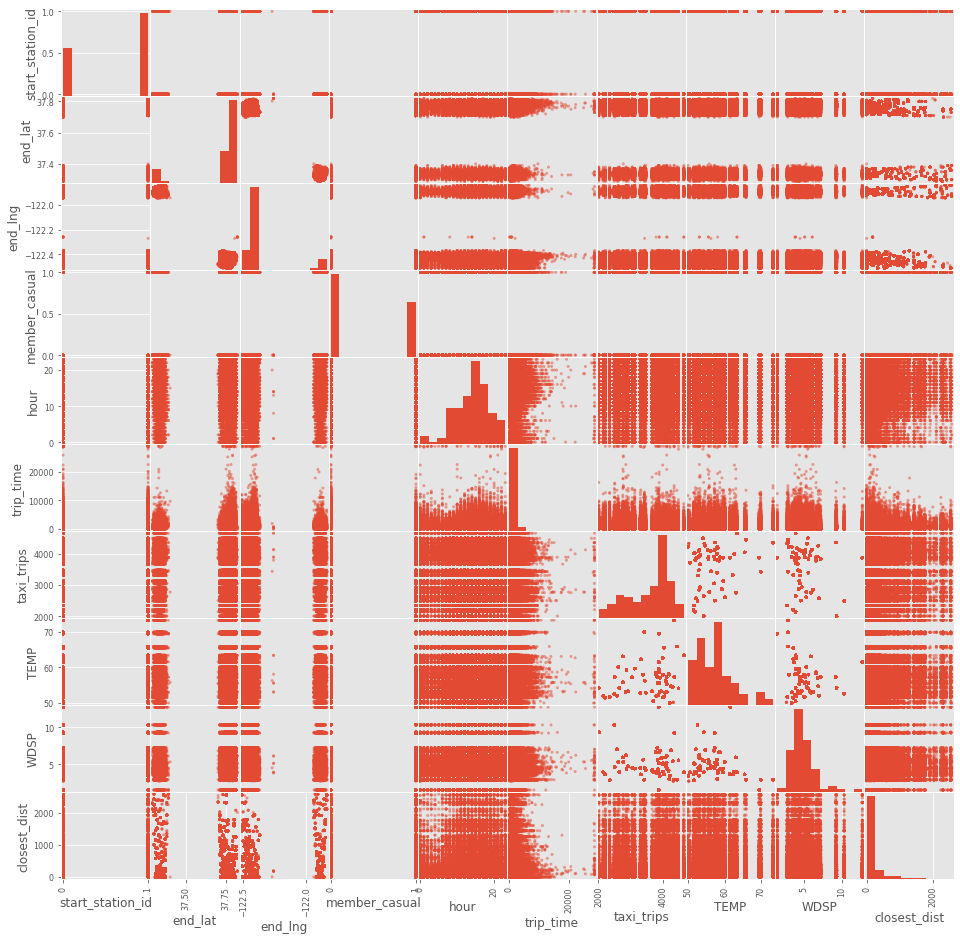

In [157]:
pd.plotting.scatter_matrix(sf2, figsize=(16, 16))

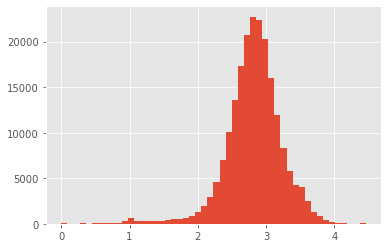

In [21]:
import math

y_log = y.apply(lambda x: 0 if x == 0 else math.log10(x))

time_log = X['trip_time'].apply(lambda x: 0 if x == 0 else math.log10(x))

fig, ax = plt.subplots()

ax.hist(time_log, bins=50);

# same thing for Chicago

In [105]:
ch1 = grab_data('data/CH/202010-divvy-tripdata.csv')
ch2 = grab_data('data/CH/202011-divvy-tripdata.csv')

# df of two cities
ch = pd.concat([ch1, ch2], ignore_index=True)

# adding traffic column
ch = ch.merge(grab_traffic('CH'), how='left', left_on='date', right_on='service_date').drop(columns='service_date')

# adding weather columns
ch = ch.merge(grab_weather('CH'), how='left', left_on='date', right_on='DATE').drop(columns='DATE')

# drop rows w/o weather data (~6,000 rows)
ch = ch[ch['TEMP'].notna()]

ch

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,total_rides,TEMP,WDSP
0,1,125.0,41.890345,-87.626068,0,2020-10-31,19,1049.0,344965.0,43.6,15.9
1,1,260.0,41.929528,-87.707818,0,2020-11-01,0,848.0,235830.0,44.7,26.7
2,1,423.0,41.791455,-87.600050,0,2020-10-31,23,501.0,344965.0,43.6,15.9
3,1,256.0,41.952809,-87.650103,0,2020-10-31,22,172.0,344965.0,43.6,15.9
4,1,185.0,41.917777,-87.691434,0,2020-10-31,19,973.0,344965.0,43.6,15.9
...,...,...,...,...,...,...,...,...,...,...,...
260305,1,261.0,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4
260306,1,134.0,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0
260307,1,134.0,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6
260308,1,623.0,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6


In [109]:
# another BIG COMPUTATION

ch_s_geo = grab_geo('CH')

ch['closest_dist'], ch['closest_id'] = zip(*ch.apply(nearest_station, args=[ch, ch_s_geo], axis=1))

ch

0.0
0.008
0.016
0.024
0.031
0.039
0.047
0.055
0.063
0.071
0.079
0.087
0.094
0.102
0.11
0.118
0.126
0.134
0.142
0.15
0.157
0.165
0.173
0.181
0.189
0.197
0.205
0.213
0.22
0.228
0.236
0.244
0.252
0.26
0.268
0.276
0.283
0.291
0.299
0.307
0.315
0.323
0.331
0.339
0.346
0.354
0.362
0.37
0.378
0.386
0.394
0.402
0.409
0.417
0.425
0.433
0.441
0.449
0.457
0.465
0.472
0.48
0.488
0.496
0.504
0.512
0.52
0.528
0.535
0.543
0.551
0.559
0.567
0.575
0.583
0.591
0.598
0.606
0.614
0.622
0.63
0.638
0.646
0.654
0.661
0.669
0.677
0.693
0.701
0.709
0.717
0.724
0.732
0.74
0.748
0.756
0.764
0.772
0.78
0.787
0.795
0.803
0.811
0.819
0.827
0.835
0.843
0.85
0.858
0.866
0.874
0.882
0.89
0.898
0.906
0.913
0.921
0.929
0.937
0.945
0.953
0.961
0.969
0.976
0.984
0.992
1.0
1.008
1.016
1.024


,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,total_rides,TEMP,WDSP,closest_dist,closest_id
0,1,125.0,41.890345,-87.626068,0,2020-10-31,19,1049.0,344965.0,43.6,15.9,0.0,125.0
1,1,260.0,41.929528,-87.707818,0,2020-11-01,0,848.0,235830.0,44.7,26.7,0.0,260.0
2,1,423.0,41.791455,-87.600050,0,2020-10-31,23,501.0,344965.0,43.6,15.9,0.0,423.0
3,1,256.0,41.952809,-87.650103,0,2020-10-31,22,172.0,344965.0,43.6,15.9,0.0,256.0
4,1,185.0,41.917777,-87.691434,0,2020-10-31,19,973.0,344965.0,43.6,15.9,0.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260305,1,261.0,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4,0.0,261.0
260306,1,134.0,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0,0.0,134.0
260307,1,134.0,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6,0.0,134.0
260308,1,623.0,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6,0.0,623.0


In [110]:
ch.describe()

,start_station_id,end_station_id,end_lat,end_lng,member_casual,hour,trip_time,total_rides,TEMP,WDSP,closest_dist,closest_id
count,254868.000000,194288.000000,254868.000000,254868.000000,254868.000000,254868.000000,254868.000000,254865.000000,254868.000000,254868.000000,254868.000000,254868.000000
mean,0.785544,235.738924,41.899345,-87.648791,0.587740,14.196117,935.094967,421537.893096,52.594333,15.878005,74.590049,258.495480
std,0.410445,168.015115,0.052784,0.032038,0.492243,4.795099,1058.603296,87672.166698,9.305609,4.268497,200.023813,175.628893
min,0.000000,2.000000,41.540000,-87.870000,0.000000,0.000000,0.000000,176309.000000,29.800000,7.900000,0.000000,2.000000
25%,1.000000,107.000000,41.880916,-87.667948,0.000000,11.000000,358.000000,365801.000000,44.300000,13.600000,0.000000,119.000000
50%,1.000000,199.000000,41.900000,-87.644515,1.000000,15.000000,625.000000,455842.000000,53.000000,15.400000,0.000000,227.000000
75%,1.000000,322.000000,41.930000,-87.629567,1.000000,18.000000,1114.000000,490759.000000,60.400000,17.800000,0.000000,350.000000
max,1.000000,731.000000,42.150000,-87.440000,1.000000,23.000000,28801.000000,532077.000000,68.000000,31.700000,13099.492207,732.000000


In [113]:
ch.to_csv('data/ch1.csv')

In [112]:
ch[ch['closest_dist'] > 0].describe()

,start_station_id,end_station_id,end_lat,end_lng,member_casual,hour,trip_time,total_rides,TEMP,WDSP,closest_dist,closest_id
count,60580.000000,0.0,60580.000000,60580.000000,60580.000000,60580.000000,60580.000000,60578.000000,60580.000000,60580.000000,60580.000000,60580.000000
mean,0.479977,NaN,41.883731,-87.653048,0.552228,14.413437,1008.713453,418624.814801,52.372219,15.944979,313.810112,331.478739
std,0.499603,NaN,0.072270,0.045591,0.497269,4.919640,1311.332319,88562.783993,9.372965,4.332178,305.379310,179.582363
min,0.000000,NaN,41.540000,-87.870000,0.000000,0.000000,0.000000,176309.000000,29.800000,7.900000,22.950094,4.000000
25%,0.000000,NaN,41.810000,-87.690000,0.000000,12.000000,325.000000,365801.000000,44.300000,13.600000,170.590341,181.000000
50%,0.000000,NaN,41.900000,-87.650000,1.000000,15.000000,621.000000,455246.000000,53.000000,15.400000,251.615914,334.000000
75%,1.000000,NaN,41.930000,-87.620000,1.000000,18.000000,1224.000000,489128.000000,60.400000,17.800000,372.877348,463.000000
max,1.000000,NaN,42.150000,-87.440000,1.000000,23.000000,28801.000000,532077.000000,68.000000,31.700000,13099.492207,732.000000


# full data sweep

In [3]:
# grab processed data from before and make a few tweaks for modeling
ch1 = pd.read_csv('data/ch1.csv', index_col='Unnamed: 0')

# drop rows w/ distances greater than 0.87km (1700 trips)
# these are more than 3 standevs away from (non-0) distance mean
#ch1 = ch1[ch1['closest_dist'] < 870]

# (fixed before hand for chicago)
# ch1['trip_time'] = abs(ch1['trip_time'])
# ch1 = ch1[ch1['TEMP'].notna()]

# renaming traffic indicator (MUST be scaled later b/c cities are being combined)
ch1.rename(columns={'total_rides':'traffic'}, inplace=True)

# 3 trips missing traffic data
ch1 = ch1[ch1['traffic'].notnull()]

ch1

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,traffic,TEMP,WDSP,closest_dist,closest_id
0,1,125.0,41.890345,-87.626068,0,2020-10-31,19,1049.0,344965.0,43.6,15.9,0.0,125.0
1,1,260.0,41.929528,-87.707818,0,2020-11-01,0,848.0,235830.0,44.7,26.7,0.0,260.0
2,1,423.0,41.791455,-87.600050,0,2020-10-31,23,501.0,344965.0,43.6,15.9,0.0,423.0
3,1,256.0,41.952809,-87.650103,0,2020-10-31,22,172.0,344965.0,43.6,15.9,0.0,256.0
4,1,185.0,41.917777,-87.691434,0,2020-10-31,19,973.0,344965.0,43.6,15.9,0.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260305,1,261.0,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4,0.0,261.0
260306,1,134.0,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0,0.0,134.0
260307,1,134.0,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6,0.0,134.0
260308,1,623.0,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6,0.0,623.0


In [4]:
# grab processed data from before and make a few tweaks for modeling
sf3 = pd.read_csv('data/sf2.csv', index_col='Unnamed: 0')

# drop rows w/o weather data (should be 0 now)
sf3 = sf3[sf3['TEMP'].notna()]

# drop rows w/ distances greater than 2.6km (1600 trips)
# these are more than 3 standevs away from (non-0) distance mean
#sf3 = sf3[sf3['closest_dist'] < 2600]

# fix negative trip times
sf3['trip_time'] = abs(sf3['trip_time'])

# renaming traffic indicator (MUST be scaled later b/c cities are being combined)
sf3.rename(columns={'taxi_trips':'traffic'}, inplace=True)

# Pull Oakland, only 8 rides and it's a different system
#sf3 = sf3[~sf3['closest_id'].str.contains('OK')]

# EXPERIMENTAL pull San Jose to see if it improves model performance (~12%)
# sf3 = sf3[~sf3['closest_id'].str.contains('SJ')]
# sf3 = sf3[~sf3['end_station_id'].str.contains('SJ')]

sf3

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,traffic,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26


In [5]:
# put cities together

df1 = pd.concat([sf3, ch1], ignore_index=True)

df1

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,traffic,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433.0,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483.0,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433.0,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483.0,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483.0,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
463688,1,261,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4,0.000000,261
463689,1,134,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0,0.000000,134
463690,1,134,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6,0.000000,134
463691,1,623,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6,0.000000,623


In [6]:
def get_city(row):
    # if df is changed beforehand the following lines will mess up
    row_vals = [val for idx, val in row.items()]
    
    stat = row_vals[12]
    
    # looks at station id to figure out which city a row is from
    if type(stat) == float:
        return 'CH'
    elif stat.find('SF') > -1:
        return 'SF'
    elif stat.find('SJ') > -1:
        return 'SJ'
    elif stat.find('San Jose Depot') > -1:
        return 'SJ'
    else:
        return 'unknown'

In [7]:
df1['city'] = df1.apply(get_city, axis=1)

# Drop where city is unknown (it's Berkeley and Oakland, CA)
df1 = df1[df1['city'] != 'unknown']

df1

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,traffic,TEMP,WDSP,closest_dist,closest_id,city
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433.0,56.3,4.5,598.937799,SJ-O11,SJ
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483.0,54.1,5.5,519.334527,SF-R26,SF
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433.0,56.3,4.5,446.831476,SF-B19,SF
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483.0,54.1,5.5,429.868101,SF-Y25,SF
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483.0,54.1,5.5,78.597538,SF-L20,SF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463688,1,261,41.871713,-87.669851,1,2020-11-07,15,464.0,353127.0,62.5,15.4,0.000000,261,CH
463689,1,134,41.877595,-87.649582,1,2020-11-27,20,465.0,328570.0,42.6,11.0,0.000000,134,CH
463690,1,134,41.877429,-87.649518,1,2020-11-08,19,943.0,260737.0,60.9,13.6,0.000000,134,CH
463691,1,623,41.872679,-87.624043,1,2020-11-08,18,903.0,260737.0,60.9,13.6,0.000000,623,CH


In [18]:
# splitting data up

X = df1.copy()

y = X['closest_dist']

X = pd.concat([X, pd.get_dummies(X['city'], drop_first=True)], axis=1)

# maybe drop TEMP too
X = X.drop(columns=['end_station_id', 'date', 'closest_id', 'closest_dist', 
                    'end_lat', 'end_lng', 'city', 'TEMP', 'WDSP'])

X['hour'] = X['hour'].apply(lambda x: math.sin(x/(24/math.pi)))
#X['trip_time'] = X['trip_time'].apply(lambda x: 0 if x == 0 else math.log10(x))


#X.rename(columns={'start_station_id':'docked_at_start', 'hour':'hour_of_day', 'member_casual':'member'})

# EXPERIMENTAL
# y = y.apply(lambda x: 0 if x == 0 else math.log10(x))

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

,start_station_id,member_casual,hour,trip_time,traffic,SF,SJ
96177,1,0,0.965926,3059.0,2505.0,1,0
368921,0,0,0.130526,14.0,467464.0,0,0
156531,0,1,0.923880,120.0,3466.0,1,0
127273,0,1,0.793353,352.0,4024.0,1,0
196923,1,1,0.991445,2271.0,3863.0,1,0
...,...,...,...,...,...,...,...
350512,1,1,0.793353,385.0,490759.0,0,0
64013,1,1,0.923880,672.0,3433.0,1,0
363850,1,0,0.707107,2585.0,465224.0,0,0
12639,0,0,0.923880,338.0,4483.0,1,0


In [19]:
# baseline model. Trying to get an RMSE better than 270!
# changes based on train test split some
y_base = np.ones(y_test.shape[0])*(y_train.mean())

mean_squared_error(y_test, y_base)**0.5

351.97810468233706

In [20]:
# Scaling data
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = sm.add_constant(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = sm.add_constant(X_test_scaled)

In [217]:
# just out of curiousity - random forest does almost same as baseline. Not encouraging...
rf = RandomForestRegressor().fit(X_train_scaled, y_train)

rfhat = rf.predict(X_test_scaled)

mean_squared_error(y_test, rfhat)**0.5

262.7118021692357

In [21]:
# Basic linear model w/ default hyperparameters
model2 = sm.OLS(y_train, X_train_scaled, hasconst=True).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           closest_dist   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5708.
Date:                Fri, 02 Apr 2021   Prob (F-statistic):               0.00
Time:                        07:22:37   Log-Likelihood:            -2.5232e+06
No. Observations:              347754   AIC:                         5.046e+06
Df Residuals:                  347746   BIC:                         5.046e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.5661      0.581    221.272      0.000     127.427     129.705
x1           -77.3324      0.598   -129.310      0.000     -78.505     -76.160
x2           -26.7831      0.606    -44.223      0.000     -27.970     -25.596
x3             1.1714      0.583      2.010      0.044       0.029       2.314
x4            34.7035      0.589     58.877      0.000      33.548      35.859
x5             4.0153      1.952      2.057      0.040       0.189       7.842
x6            32.6088      1.923     16.954      0.000      28.839      36.379
x7            54.9295      1.053     52.182      0.000      52.866      56.993
==============================================================================
Omnibus:                   464341.397   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        178819380.936
Skew:                           7.444   Prob(JB):                         0.00
Kurtosis:                     113.088   Cond. No.                         6.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
vif = pd.DataFrame()
vif['feature'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif

,feature,VIF
0,start_station_id,3.573957
1,member_casual,2.151814
2,hour,9.993349
3,trip_time,1.777613
4,traffic,7.121409
5,SF,5.213451
6,SJ,1.534705


#### OLS interpretation
Condition number is low (less than 20) so multicolinearity is probabily not a problem ([article](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)).  
Most features have a p-value less than 0.05 so probably affect the dependent variable. Temperature and wind speed were above that threshold so we fail to say have an effect (?).  
When these two are removed, all are below 0.05.

#### variance inflation factor
What should the cut off be for saying there is colinearity? TEMP was 40 while the rest were 2-18. When TEMP and WDSP removed, all below 10. Hour and traffic somewhat colinear (9 and 7) but that's not too surprising.

In [26]:
# Do CV to see if you need any regularization

def cross_val(X_train, y_train, k):
    rmse_arr = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X_train):
        Kx_train, Kx_test = X_train[train_index], X_train[test_index]
        Ky_train, Ky_test = y_train.iloc[train_index], y_train.iloc[test_index]
        mod = sm.OLS(Ky_train, Kx_train, hasconst=True).fit()
        train_predicted = mod.predict(Kx_test)
        cur_rmse = mean_squared_error(Ky_test, train_predicted)**0.5
        rmse_arr.append(cur_rmse)
    return np.average(rmse_arr)

In [27]:
# Model training error found using cross validation

model1_err = cross_val(X_train_scaled, y_train, k=5)

model1_err

342.42969938974306

In [25]:
# Model testing error. Difference between training error and testing error is almost none.
# This means our model is probably not overfitting and doesn't need regularization.

yhat = model2.predict(X_test_scaled)

mean_squared_error(y_test, yhat)**0.5

333.0044082275358

In [108]:
# These two cells are for adding regularization anyways :P

# home grown cross validation for tuning alpha

def cross_val_ols(X_train, y_train, k, alpha):
    rmse_arr = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X_train):
        Kx_train, Kx_test = X_train[train_index], X_train[test_index]
        Ky_train, Ky_test = y_train.iloc[train_index], y_train.iloc[test_index]
        mod = sm.OLS(y_train, X_train).fit_regularized(alpha=alpha)
        train_predicted = mod.predict(Kx_test)
        cur_rmse = rmse(Ky_test, train_predicted)
        rmse_arr.append(cur_rmse)
    return np.average(rmse_arr)

In [109]:
# trying different alpha levels

lowest_err = 1000

for a in np.linspace(0, 1, 11):
    err = cross_val_ols(X_train_scaled, y_train, k=5, alpha=a)
    if err < lowest_err:
        lowest_err = err
        lowest_alpha = a

print(lowest_alpha, lowest_err)

0.0 341.5912724258344


In [106]:
# getting residuals to look for patterns

resid = yhat - y_test

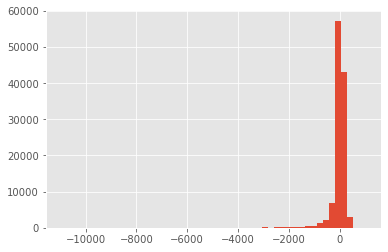

In [107]:
# residuals histogram looks mostly centered around 0 with some negative skew
# (some guesses are much lower than actual values)

fig, ax = plt.subplots()

ax.hist(resid, bins=50);

<BarContainer object of 4 artists>

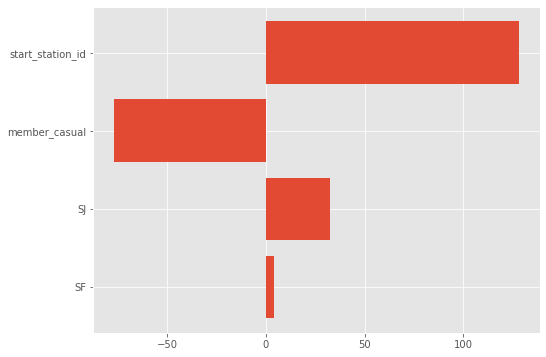

In [28]:
# categorical feature weights
fix, ax = plt.subplots(figsize=(8,6))

ax.barh(X_train.columns[[5,6,1,0]], model2.params[[5,6,1,0]])

<BarContainer object of 3 artists>

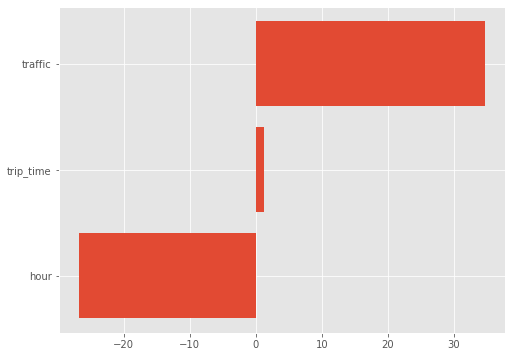

In [29]:
# numeric feature weights
fix, ax = plt.subplots(figsize=(8,6))

ax.barh(X_train.columns[[2,3,4]], model2.params[[2,3,4]])

Important note!

These are the features weights this model used to make its predictions. This graph has several caveats, the first and largest being that this model did only barely better than baseline (about 6%). Even though all the assumptions of independent identical distributed data hold up and these weights are therefor interpretabile, they only contribute to the target variable a little bit. There is still a lot of noise or, more likely, important features we haven't included. But where this model has suceeded let's see what it tells us.

First from the categorical features: Picking a bike from a station directly as opposed to finding one somewhere means it will likely be farther from a dock at drop off (or you could say less likely to be docked). If a rider has a membership with the bikeshare company, the bike is likely to be docked closer. Bikes in San Francisco and Chicago are about dropped off at about the same distance, but bikes in San Jose are likely dropped off farther away.

Next from numeric features: More traffic and longer trips mean bikes are likely dropped off farther from stations. As it gets later in the day bikes are likely closer to stations. It is tempting to compare the relative effects, however these bars represent one "unit" of each. These are all measured in different ways and the amount of fluctuation varies greatly between them.

Cross referencing this with descriptive statistics of the data should support or refute some of these inferences. The mean station distance for a bike riden by a member was 80m, while that of a non-member was 140m. This is in line with our model inference that implied members are likely to leave their bikes closer to stations. Using this same method of cross referencing on other features we find that the inferences from city are supported by the data while start station is not.



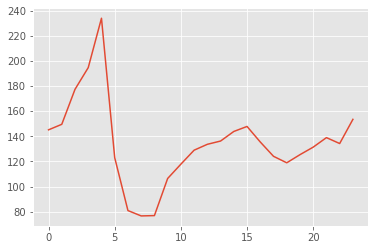

In [181]:
# hour of day vs average distance
# difficult to capture by saying "decreases over time"
fig, ax = plt.subplots()

ax.plot(np.arange(24), df1.groupby('hour').agg('mean').closest_dist);

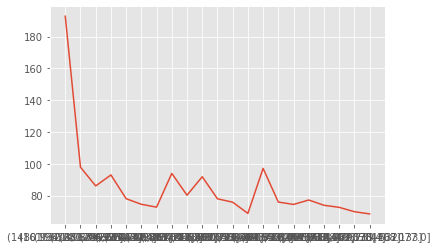

In [182]:
# traffic measure vs average distance
# distance certainly goes down as traffic goes up
df2 = df1.copy()

df2['bins'] = pd.cut(df2['traffic'], bins=30)

df2 = df2.groupby(df2['bins']).agg('mean').dropna()

#df2 = df2.reset_index()

fig, ax = plt.subplots()

ax.plot(df2.index.astype(str), df2['closest_dist'])

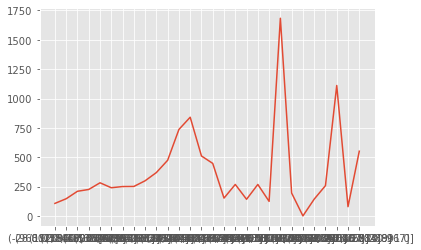

In [183]:
# trip time vs average distance
# has quite a bit of variability, but perhaps slightly higher as trips get longer
df2 = df1.copy()

df2['bins'] = pd.cut(df2['trip_time'], bins=30)

df2 = df2.groupby(df2['bins']).agg('mean').dropna()

#df2 = df2.reset_index()

fig, ax = plt.subplots()

ax.plot(df2.index.astype(str), df2['closest_dist'])

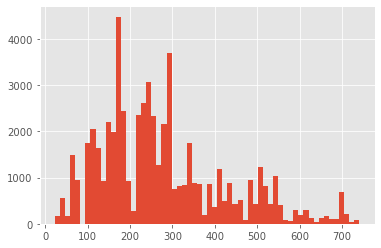

In [261]:
# graph of nearest distances that aren't 0 and less than 750m
fig, ax = plt.subplots()

yp = ch1['closest_dist']

yp = yp[yp>0]
yp = yp[yp<750]

ax.hist(yp, bins=60);


In [39]:
st = 298

# first spike is 1/2 station 423 (U of CH, close to hyde park)
# second spike is almost all station 121 (Hyde park)
mask = (ch1['closest_dist'] > st -6) & (ch1['closest_dist'] < st +6)# & (ch1['closest_id'] == 423)

ch1[mask].closest_id.value_counts()

121.0    2551
499.0     373
496.0     221
415.0      92
597.0      86
129.0      86
684.0      81
690.0      56
679.0      29
408.0      15
412.0      10
551.0       8
Name: closest_id, dtype: int64

In [252]:
def graph_distances(city, ax):
#     # Grab full data from desired city
#     if city == 'SF':
#         y = pd.read_csv('data/sf2.csv', usecols=['closest_id'])
#         c = 'San Francisco'
#     elif city == 'CH':
#         y = pd.read_csv('data/ch1.csv', usecols=['closest_id'])
#         c = 'Chicago'
#     else:
#         return None
    
    #delete these 2 lines
    y = ch1['closest_dist']
    c = 'Chicago'
    
    y = y[y > 0]
    y = y[y < 750]
    
    ax.hist(y, bins=60)
    ax.set_xlabel('Distance from Nearest Station (m)', fontsize=14)
    ax.set_ylabel('Frequency\n(Number of Rides)', fontsize=14)
    ax.set_title('Distance from Nearest Station Histogram - {}'.format(c), fontsize=16)

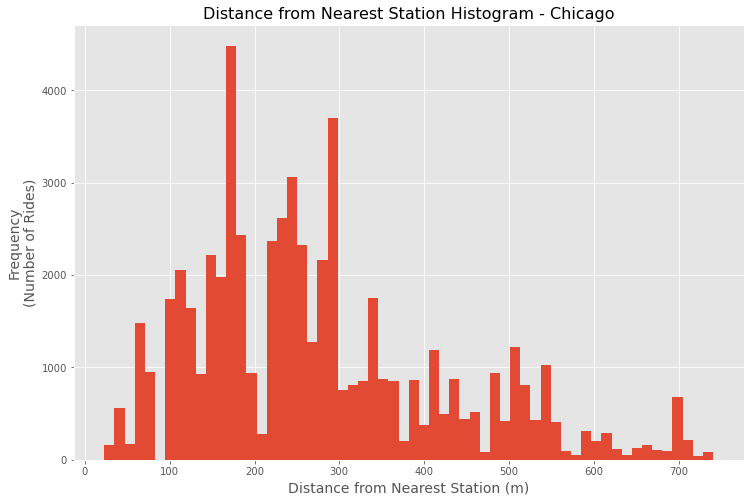

In [262]:
#asdf = pd.read_csv('data/ch1.csv', usecols=['closest_id'])

fig, ax = plt.subplots(figsize=(12,8))

graph_distances('CH', ax)

In [47]:
# among trips not docked, this is a list of stations 
# and the count of bikes nearest them and average distances from them

ch_s_geo = grab_geo('CH')

y_stations = ch1[ch1['closest_dist'] > 0]

y_stations = y_stations[['closest_id', 'closest_dist']]

# can sort by count or by mean, just change argument in sort_values()
y_stations = y_stations.groupby('closest_id').agg(['mean', 'count']).sort_values(('closest_dist', 'count'), ascending=False)

y_stations.merge(ch_s_geo, left_index=True, right_index=True)

/home/nicholas/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(closest_dist, mean)","(closest_dist, count)",end_lat,end_lng
121.0,294.479776,2551,41.802634,-87.590405
423.0,170.590341,2161,41.791533,-87.599875
425.0,244.106665,1348,41.788141,-87.588433
418.0,108.180761,1345,41.799355,-87.600976
181.0,164.860696,1255,41.890777,-87.631693
...,...,...,...,...
723.0,128.108473,3,41.699215,-87.668873
732.0,365.816186,3,41.648501,-87.546090
529.0,559.497575,2,41.886861,-87.745272
730.0,615.031656,2,41.691320,-87.712825


Top 5 nearest but undocked stations in Chicago: [map](https://www.mapdevelopers.com/draw-circle-tool.php?circles=%5B%5B288.02%2C41.7999774%2C-87.5901747%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B166.78%2C41.7916323%2C-87.599791%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B242.8%2C41.7880507%2C-87.5884139%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B108.23%2C41.799263%2C-87.6008759%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%2C%5B159.79%2C41.8909715%2C-87.6318562%2C%22%23AAAAAA%22%2C%22%23000000%22%2C0.4%5D%5D)

In [42]:
ch1.closest_id.value_counts()

121.0    2854
423.0    2591
140.0    2146
181.0    2114
176.0    2008
         ... 
409.0       2
545.0       2
564.0       1
562.0       1
400.0       1
Name: closest_id, Length: 663, dtype: int64

In [265]:
asdf = pd.read_csv('data/CH/202011-divvy-tripdata.csv')

asdf[asdf['start_station_id'] == 423]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
765,9BB1D29689779E05,electric_bike,2020-11-10 07:59:33,2020-11-10 08:06:37,University Ave & 57th St,423.0,Cornell Ave & Hyde Park Blvd,417.0,41.791462,-87.600103,41.802269,-87.586779,casual
1073,569E1C3C7B0B9A83,electric_bike,2020-11-12 11:08:58,2020-11-12 11:14:53,University Ave & 57th St,423.0,Shore Dr & 55th St,247.0,41.791488,-87.600134,41.795209,-87.580953,casual
2077,E83A350979A9EDEC,electric_bike,2020-11-12 12:40:46,2020-11-12 14:20:05,University Ave & 57th St,423.0,NaN,NaN,41.791501,-87.599947,41.900000,-87.620000,casual
5406,937D1CA5A548E0C3,electric_bike,2020-11-18 09:46:51,2020-11-18 09:47:19,University Ave & 57th St,423.0,NaN,NaN,41.791478,-87.600138,41.790000,-87.600000,casual
9019,3CCBF50624006087,electric_bike,2020-11-30 10:14:20,2020-11-30 10:28:23,University Ave & 57th St,423.0,NaN,NaN,41.791451,-87.600053,41.800000,-87.600000,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257839,B0B408519C34CE93,docked_bike,2020-11-16 20:41:51,2020-11-16 20:45:36,University Ave & 57th St,423.0,Ellis Ave & 60th St,426.0,41.791478,-87.599861,41.785097,-87.601073,member
258140,69FCA819BCEFA87E,docked_bike,2020-11-02 18:23:53,2020-11-02 18:31:07,University Ave & 57th St,423.0,Ellis Ave & 60th St,426.0,41.791478,-87.599861,41.785097,-87.601073,member
258669,452C989BB9502A69,docked_bike,2020-11-06 16:08:23,2020-11-06 16:19:14,University Ave & 57th St,423.0,Lake Park Ave & 56th St,345.0,41.791478,-87.599861,41.793242,-87.587782,casual
259061,0BDCA9F94104D98B,electric_bike,2020-11-12 19:00:22,2020-11-12 19:04:11,University Ave & 57th St,423.0,Ellis Ave & 60th St,426.0,41.791505,-87.599908,41.785148,-87.601085,member


# Clustering

In [64]:
# Read back in saved data
ch = pd.read_csv('data/ch.csv', index_col='Unnamed: 0')
sf = pd.read_csv('data/sf.csv', index_col='Unnamed: 0')

In [7]:
ch1 = ch[ch['closest_dist'] > 0]

ch1 = ch1.drop(columns=['start_station_id', 'end_station_id', 'member_casual', 'trip_time', 'WDSP'])

ch1

,end_lat,end_lng,date,hour,traffic,TEMP,closest_dist,closest_id
14,41.72,-87.57,2020-10-28,21,484376.0,40.5,504.804039,731.0
30,41.76,-87.61,2020-10-26,18,449442.0,40.2,343.140756,570.0
32,41.89,-87.63,2020-10-26,9,449442.0,40.2,164.860696,181.0
33,41.94,-87.70,2020-10-13,13,505143.0,59.9,240.336492,498.0
34,41.86,-87.69,2020-10-13,14,505143.0,59.9,352.931567,437.0
...,...,...,...,...,...,...,...,...
260299,41.95,-87.65,2020-11-18,13,428576.0,42.9,152.506696,304.0
260300,41.97,-87.74,2020-11-13,12,464889.0,41.4,1054.041057,630.0
260301,41.96,-87.71,2020-11-24,13,399619.0,40.2,363.589000,480.0
260302,41.96,-87.71,2020-11-25,19,399491.0,45.1,363.589000,480.0


In [61]:
def cluster_prep(city='ch'):
    
    # grab data from which city?
    if city == 'ch':
        urls = ['data/CH/202010-divvy-tripdata.csv', 'data/CH/202011-divvy-tripdata.csv']
    elif city == 'sf':
        urls = ['data/SF/202010-baywheels-tripdata.csv', 'data/SF/202011-baywheels-tripdata.csv']
    else:
        return None

    # only using two months so pretty simple concat
    df1 = pd.read_csv(urls[0])
    df2 = pd.read_csv(urls[1])
    
    df = pd.concat([df1, df2], ignore_index=True)

    # drop rows w/o lat/long coordinates
    df = df[df['end_lat'].notna()]
    
    # drop rows where bikes were docked (where they have an end station id)
    df = df[~df['end_station_id'].notna()]

#     # drop non-electric bikes
#     df = df[df['rideable_type'] == 'electric_bike']
    
#     # grab date (for data matching)
#     df['ended_at'] = pd.to_datetime(df['ended_at'])
#     df['date'] = pd.to_datetime(df['ended_at'].dt.date)
    
#     # add a few time related features
#     df['hour'] = df['ended_at'].dt.hour
    
#     df['started_at'] = pd.to_datetime(df['started_at'])
    
#     # daylight savings makes a few negative trip times, a quick approx. fix is okay
#     df['trip_time'] = abs((df['ended_at'] - df['started_at']).dt.total_seconds())
    
#     # binary encoding for a few categorical features
#     df['start_station_id'] = df['start_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)
#     df['member_casual'] = df['member_casual'].apply(lambda x: 0 if x=='casual' else 1)
    
#     # reset index and drop columns not being used
#     df.reset_index(drop=True)
    
#     df = df.drop(columns=['rideable_type'])

    df = df[['end_lat', 'end_lng']]

    return df

ch = cluster_prep()

In [62]:
sf = cluster_prep('sf')
ch = cluster_prep('ch')

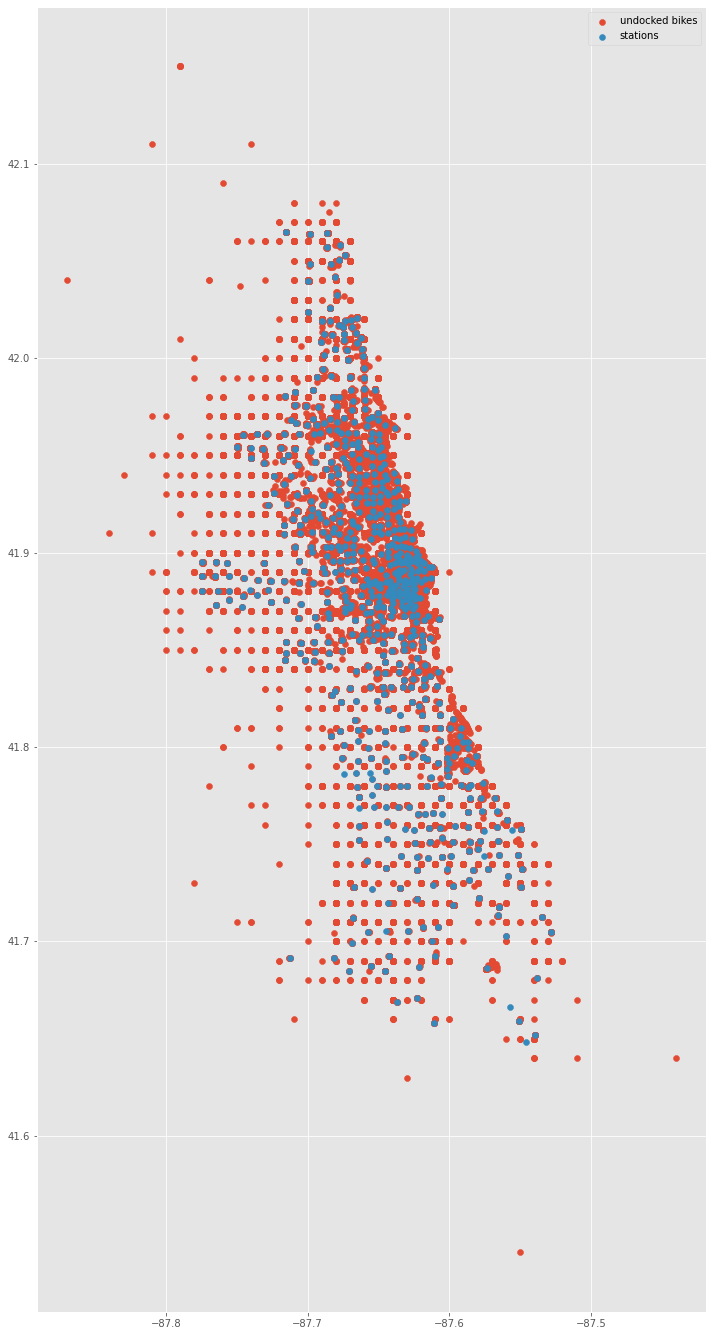

In [66]:
# Chicago
fig, ax = plt.subplots(figsize=(12,24))

ax.scatter(ch['end_lng'], ch['end_lat'], label='undocked bikes')
ax.scatter(ch_s_geo['end_lng'], ch_s_geo['end_lat'], label='stations')
ax.legend();

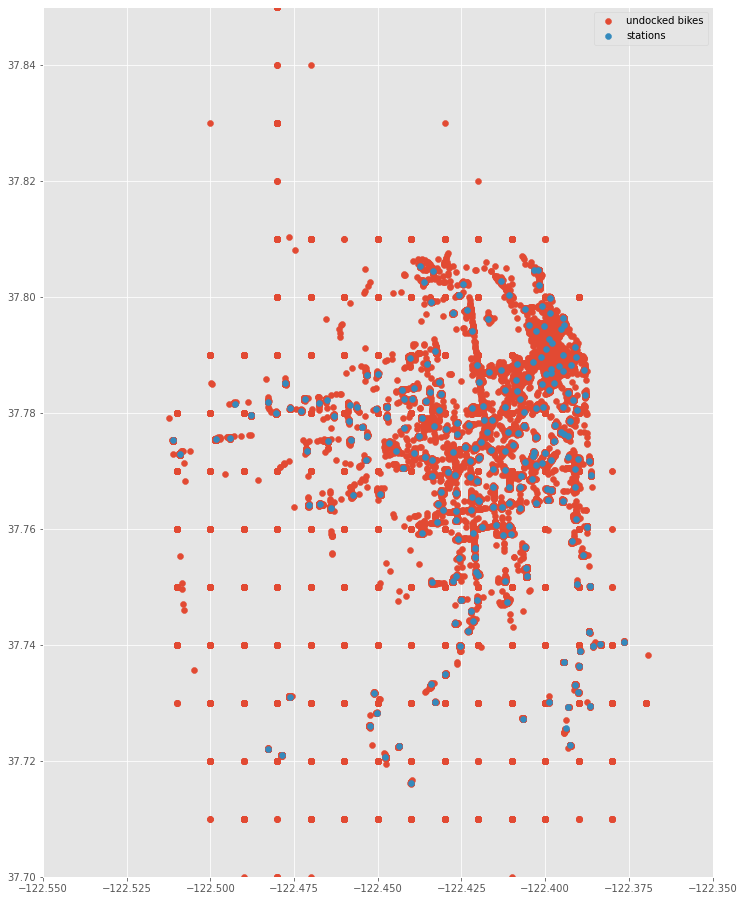

In [65]:
# San Francisco
fig, ax = plt.subplots(figsize=(12,16))

ax.scatter(sf['end_lng'], sf['end_lat'], label='undocked bikes')
ax.scatter(sf_s_geo['end_lng'], sf_s_geo['end_lat'], label='stations')
ax.legend()

ax.set_ylim(37.7, 37.85)
ax.set_xlim(-122.55, -122.35);

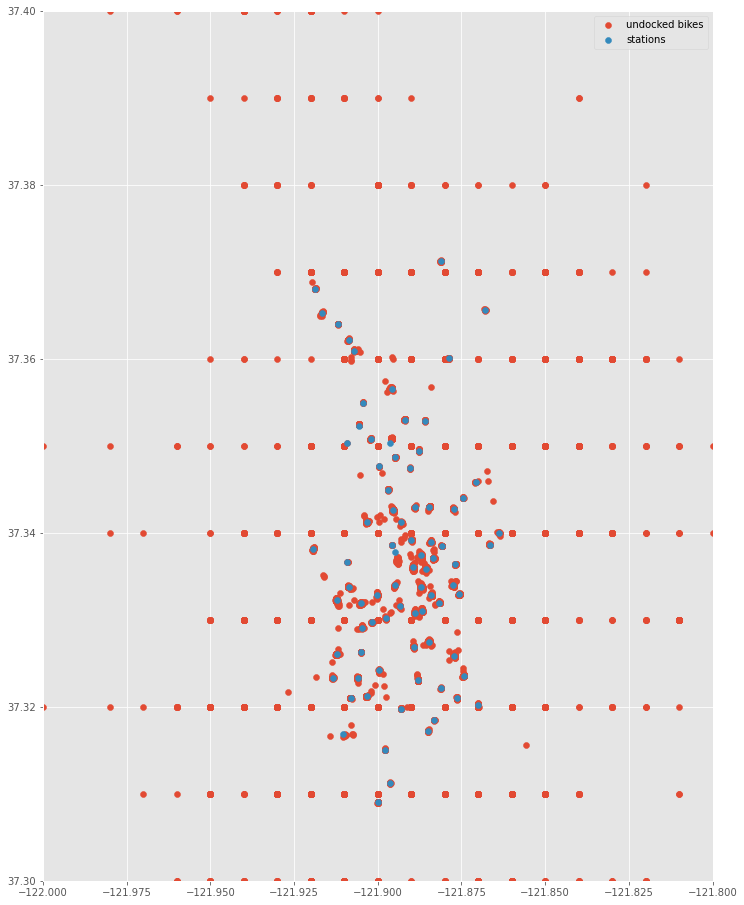

In [68]:
# San Jose

fig, ax = plt.subplots(figsize=(12,16))

ax.scatter(sf['end_lng'], sf['end_lat'], label='undocked bikes')
ax.scatter(sf_s_geo['end_lng'], sf_s_geo['end_lat'], label='stations')
ax.legend()

ax.set_ylim(37.3, 37.4)
ax.set_xlim(-122, -121.8);

In [69]:
blah = pd.read_csv('data/SF/202010-baywheels-tripdata.csv')

#blah = blah[~blah['end_station_id'].notna()]

blah

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,DAFE69F6EA89E3DC,electric_bike,2020-10-31 13:50:15,2020-10-31 14:02:15,NaN,NaN,NaN,NaN,37.340000,-121.890000,37.330000,-121.870000,casual
1,AD09094F86C45E90,electric_bike,2020-10-30 21:18:18,2020-10-30 21:27:47,NaN,NaN,NaN,NaN,37.760000,-122.420000,37.750000,-122.400000,casual
2,9ED766B44303995B,electric_bike,2020-10-31 16:55:01,2020-10-31 17:02:27,NaN,NaN,NaN,NaN,37.800000,-122.430000,37.800000,-122.440000,casual
3,AB7B66F7E79EADB2,electric_bike,2020-10-30 21:57:57,2020-10-30 22:28:22,NaN,NaN,NaN,NaN,37.730000,-122.400000,37.730000,-122.410000,casual
4,C7912C959C4399C4,electric_bike,2020-10-30 17:10:26,2020-10-30 17:16:04,NaN,NaN,NaN,NaN,37.760000,-122.430000,37.770000,-122.430000,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167536,0C8F9B30E5A8795E,electric_bike,2020-10-30 20:13:32,2020-10-30 20:37:14,Post St at Kearny St,SF-F27,Carl St at Cole St,SF-M15,37.789134,-122.403557,37.765958,-122.449482,casual
167537,F2DE7DE63E1D50DA,electric_bike,2020-10-01 16:10:51,2020-10-01 16:34:44,Post St at Kearny St,SF-F27,Carl St at Cole St,SF-M15,37.789042,-122.403401,37.765931,-122.449308,casual
167538,C398FFAD9C3DF53D,electric_bike,2020-10-26 17:14:12,2020-10-26 17:38:56,Post St at Kearny St,SF-F27,Carl St at Cole St,SF-M15,37.789110,-122.403244,37.765935,-122.449313,member
167539,3EE37B8042D06642,electric_bike,2020-10-24 14:36:51,2020-10-24 14:44:30,Page St at Scott St,SF-K19,Carl St at Cole St,SF-M15,37.772420,-122.435730,37.765934,-122.449296,member


In [67]:
sf

,start_station_id,end_station_id,end_lat,end_lng,member_casual,date,hour,trip_time,traffic,TEMP,WDSP,closest_dist,closest_id
0,0,NaN,37.330000,-121.870000,0,2020-10-31,14,720.0,3433,56.3,4.5,598.937799,SJ-O11
1,0,NaN,37.750000,-122.400000,0,2020-10-30,21,569.0,4483,54.1,5.5,519.334527,SF-R26
2,0,NaN,37.800000,-122.440000,0,2020-10-31,17,446.0,3433,56.3,4.5,446.831476,SF-B19
3,0,NaN,37.730000,-122.410000,0,2020-10-30,22,1825.0,4483,54.1,5.5,429.868101,SF-Y25
4,0,NaN,37.770000,-122.430000,0,2020-10-30,17,338.0,4483,54.1,5.5,78.597538,SF-L20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212289,1,SF-J26,37.777909,-122.406205,1,2020-11-13,3,3003.0,4072,52.9,5.9,0.000000,SF-J26
212290,1,SF-J26,37.777693,-122.406371,1,2020-11-08,17,2860.0,2491,52.6,10.3,0.000000,SF-J26
212291,1,SF-J26,37.777872,-122.406261,1,2020-11-14,15,320.0,2850,53.1,6.2,0.000000,SF-J26
212292,1,SF-J26,37.777834,-122.406190,1,2020-11-12,17,840.0,4024,51.8,5.0,0.000000,SF-J26
